<a href="https://colab.research.google.com/github/gojiteji/AIorNOT/blob/main/AIORNOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()

In [2]:
!pip install datasets
!pip install flax==0.6.2
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid.
Cannot authenticate through git-credential as no help

In [3]:
from datasets import load_dataset
dataset = load_dataset("competitions/aiornot")

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from huggingface_hub import hf_hub_download
file_path = hf_hub_download('competitions/aiornot', '.extras/sample_submission.csv', repo_type='dataset')
import pandas as pd
df = pd.read_csv(file_path)

In [5]:
import flax
import flax.linen as nn
import optax
import jax.numpy as np

In [6]:
class CNNClassifier(nn.Module):
  def setup(self):
    self.conv1 = nn.Conv(features=16, kernel_size=(3, 3))
    self.conv2 = nn.Conv(features=32, kernel_size=(3, 3))
    self.dense1 = nn.Dense(features=128)
    self.dense2 = nn.Dense(features=1)
  def __call__(self, x):
    x = self.conv1(x)
    x = nn.leaky_relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = self.conv2(x)
    x = nn.leaky_relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.dense1(x)
    x = nn.leaky_relu(x)
    x = self.dense2(x)
    return x

In [7]:
model=CNNClassifier()

In [8]:
from functools import partial

In [9]:
##for pmap
#@partial(jax.pmap,axis_name="devices")
@jax.jit
def training_step(state,images,labels):
  def loss_fn(params):
    logits=state.apply_fn({'params': params}, images)
    loss=optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels).mean()
    return loss
  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)
  ##for pmap
  #grads = jax.lax.pmean(grads,axis_name="devices")
  state = state.apply_gradients(grads=grads)
  return state, loss

In [10]:
num_epochs = 12
device_count = jax.device_count()
batch_size = 32*device_count

from flax.training.train_state import TrainState
tx = optax.adamw(5e-5)
params = model.init(jax.random.PRNGKey(0), np.ones((batch_size//device_count,512,512,3)))['params']
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
from flax import jax_utils
##for pmap
#state = jax_utils.replicate(state)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [16]:
dataloader = DataLoader(dataset["train"].with_format("np"), batch_size=batch_size)

loss_list=[]
for epoch in tqdm(range(num_epochs)):
  epoch_loss=[]
  for batch in dataloader:
    ##for pmap
    #images = np.array(batch["image"].reshape([device_count,-1,512,512,3]))
    #labels = np.array(batch["label"].reshape([device_count,-1]))
    images = np.array(batch["image"].reshape([-1,512,512,3]))
    labels = np.array(batch["label"])
    state, loss = training_step(state,images,labels)
    epoch_loss.append(loss)
  loss_list.append(np.mean(np.array(epoch_loss)))
  print("loss:",np.mean(np.array(epoch_loss)))

  8%|▊         | 1/12 [01:44<19:06, 104.18s/it]

loss: 1.4895427


 17%|█▋        | 2/12 [03:25<17:02, 102.28s/it]

loss: 1.4317279


 25%|██▌       | 3/12 [05:04<15:08, 100.96s/it]

loss: 1.1425977


 33%|███▎      | 4/12 [06:45<13:27, 100.99s/it]

loss: 1.3273638


 42%|████▏     | 5/12 [08:25<11:45, 100.78s/it]

loss: 1.092208


 50%|█████     | 6/12 [10:05<10:02, 100.40s/it]

loss: 0.9084493


 58%|█████▊    | 7/12 [11:44<08:19, 100.00s/it]

loss: 0.7609631


 67%|██████▋   | 8/12 [13:25<06:40, 100.22s/it]

loss: 0.7179781


 75%|███████▌  | 9/12 [15:04<04:59, 99.84s/it] 

loss: 0.69643724


 83%|████████▎ | 10/12 [16:42<03:18, 99.34s/it]

loss: 0.6942279


 92%|█████████▏| 11/12 [18:19<01:38, 98.56s/it]

loss: 0.6958133


100%|██████████| 12/12 [19:56<00:00, 99.70s/it]

loss: 0.6935841


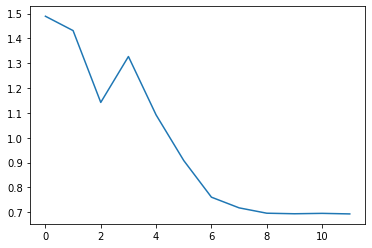

In [17]:
import matplotlib.pyplot as plt
plt.plot(loss_list);plt.show()

In [ ]:
"""save and load
ckpt_dir="checkpoint"
from flax.training import checkpoints
target={"state":state}
checkpoints.save_checkpoint(ckpt_dir=ckpt_dir,target=target,step=0,overwrite=False,keep=1)
state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=None)["state"]
"""

In [18]:
@jax.jit
def test_step(state,images):
  logits = state.apply_fn({'params': params}, images)
  return logits
print("===test step===")
dataloader = DataLoader(dataset["test"].with_format("np"), batch_size=batch_size)
logit_list=[]
for batch in tqdm(dataloader):
  images = np.array(batch["image"].reshape([-1,512,512,3]))
  logits = test_step(state,images)
  logit_list.append(logits)

===test step===


100%|██████████| 1358/1358 [04:00<00:00,  5.65it/s]


In [35]:
preds=list(map(lambda x:int(x[0]>0.5),np.vstack(logit_list).tolist()))
df["label"]=preds
df.to_csv('submission.csv', index=False)